In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10
try:
    from torchsummary import summary
except:
    print("Torchsummary not installed\nInstalling...")
    !pip install torchsummary
    from torchsummary import summary
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
import os
import random
import requests
from PIL import Image
import io

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Generative modeling --> use the entire dataset

train_dataset = CIFAR10(
    root="./data",
    train=True,
    download=True,
)

test_dataset = CIFAR10(
    root="./data",
    train=False,
    download=True,
)

# VAE Training

In [5]:
# Adapted from https://www.kaggle.com/code/leoliu1415/convolutional-vae-on-cifar10
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
        
    def forward(self, x):
        return x.view(self.shape)
    
class Trim(nn.Module):
    def __init__(self):
        super(Trim, self).__init__()
    
    def forward(self, x):
        return x[:, :, :32, :32] # asymmetrical trimming to feed to ConvTranspose layers (counteract padding/stride size adjustments)

class VAE(nn.Module):
    def __init__(self, latent_dim=100):
        
        # [(W−K+2P)/S]+1
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.conv1   = nn.Conv2d(3, 32, 3, stride=2, padding=1)    # [B, 3, 32, 32]   → [B, 32, 16, 16]
        self.conv2   = nn.Conv2d(32, 64, 3, stride=2, padding=1)   # [B, 32, 16, 16]  → [B, 64, 8, 8]
        self.conv3   = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # [B, 64, 8, 8]    → [B, 128, 4, 4]
        self.flatten = nn.Flatten()                                # [B, 128, 4, 4]   → [B, 2048]
        
        self.linear_mean   = nn.Linear(2048, self.latent_dim)                   # [B, 2048]        → [B, latent_dim]
        self.linear_logvar = nn.Linear(2048, self.latent_dim)                   # [B, 2048]        → [B, latent_dim]
        
        # Decoder
        self.linear   = nn.Linear(self.latent_dim, 2048)                        # [B, latent_dim]          → [B, 2048]
        self.reshape  = Reshape(-1, 128, 4, 4)                     # [B, 2048]        → [B, 128, 4, 4]
        
        self.deconv1  = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=0)  # [B, 128, 4, 4] → [B, 64, 9, 9]
        self.deconv2  = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1)   # [B, 64, 9, 9]  → [B, 32, 17, 17]
        self.deconv3  = nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1)    # [B, 32, 17, 17] → [B, 3, 33, 33]
        
        self.trim     = Trim()                                     # [B, 3, 33, 33]   → [B, 3, 32, 32]

    
    def reparameterize(self, mean, var):
        eps = torch.randn(mean.size(0), mean.size(1)).to(device)
        z = mean + eps * torch.exp(var / 2.)
        return z

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.flatten(x)
        mean = self.linear_mean(x)
        var = self.linear_logvar(x)
        z = self.reparameterize(mean, var)
        return mean, var, z

    def decode(self, z):
        z = self.linear(z)
        z = self.reshape(z)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        z = self.trim(z)
        z = F.sigmoid(z)
        return z
    
    def forward(self, x):
        mean, var, z = self.encode(x)
        z = self.decode(z)
        return mean, var, z

In [56]:
summary(model=VAE(latent_dim=64).to(device), input_size=(3, 32, 32))

summary(model=VAE(latent_dim=128).to(device), input_size=(3, 32, 32))

summary(model=VAE(latent_dim=256).to(device), input_size=(3, 32, 32))

VAE(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_mean): Linear(in_features=2048, out_features=256, bias=True)
  (linear_logvar): Linear(in_features=2048, out_features=256, bias=True)
  (linear): Linear(in_features=256, out_features=2048, bias=True)
  (reshape): Reshape()
  (deconv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (trim): Trim()
)

In [7]:
class VAETrainer:
    def __init__(self, model, train_dataset, test_dataset=None, device=None,
                 batch_size=128, lr=1e-3, epochs=50, kl_start_weight=0, beta=0.000075, anneal=True):
        self.model = model
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        transform = transforms.ToTensor()
                
                # Apply transform to each dataset before concat
        if train_dataset is not None:
            train_dataset.transform = transform
        if test_dataset is not None:
            test_dataset.transform = transform
        
        self.dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset]) if test_dataset else train_dataset
        
        self.dataloader = DataLoader(
            dataset=self.dataset,
            batch_size=batch_size,
            shuffle=False
        )

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.epochs = epochs
        self.kl_start_weight = kl_start_weight
        self.beta = beta
        self.anneal = anneal

        self.history = {"train_loss": [], "recon_loss": [], "kl_loss": []}

        # Output dirs
        self.latent_dim = self.model.latent_dim
        self.save_mode = "anneal" if self.anneal else "no_anneal"
        self.base_dir = os.path.join("./VAE/results", self.save_mode, str(self.latent_dim))
        os.makedirs(self.base_dir, exist_ok=True)
        os.makedirs("./VAE/models", exist_ok=True)

    def loss_function(self, recon_x, x, mean, logvar, epoch):
        recon_loss = F.mse_loss(recon_x, x, reduction="sum")

        kl_end_weight = 1.0
        anneal_rate = (kl_end_weight - self.kl_start_weight) / self.epochs
        kl_weight = min(kl_end_weight, self.kl_start_weight + anneal_rate * epoch)

        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        if self.anneal:
            return recon_loss + kl_weight * kl_loss, recon_loss, kl_loss
        else:
            return recon_loss + self.beta * kl_loss, recon_loss, kl_loss

    def train_epoch(self, epoch):
        self.model.train()
        total_loss, total_recon, total_kl = 0, 0, 0

        for xb, _ in self.dataloader:
            xb = xb.to(self.device)

            mean, logvar, recon = self.model(xb)
            loss, recon_loss, kl_loss = self.loss_function(recon, xb, mean, logvar, epoch)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()

        n = len(self.dataloader.dataset)
        return total_loss / n, total_recon / n, total_kl / n

    def fit(self):
        for epoch in range(self.epochs):
            train_loss, recon_loss, kl_loss = self.train_epoch(epoch)
            self.history["train_loss"].append(train_loss)
            self.history["recon_loss"].append(recon_loss)
            self.history["kl_loss"].append(kl_loss)

            print(f"Epoch [{epoch + 1}/{self.epochs}] "
                  f"Train: {train_loss:.4f} (Recon: {recon_loss:.4f}, KL: {kl_loss:.4f})")

            if (epoch + 1) % 5 == 0:
                save = False
                if (epoch + 1) in [5, 25, 50]:
                    save = True
                self.plot_losses(show=True, save=False)   # just display
                self.show_reconstructions(n=8, epoch=epoch+1, show=True, save=save)
                self.show_random_samples(n=8, epoch=epoch+1, save=save)
        
        # end of training
        self.plot_losses(show=False, save=True, epoch=self.epochs)  # save final curve
        self.plot_latent_space(save=True)
        self.save_model()

    def plot_losses(self, show=True, save=False, epoch=None):
        plt.figure(figsize=(8,5))
        plt.plot(self.history["train_loss"], label="Total Loss")
        plt.plot(self.history["recon_loss"], label="Reconstruction Loss")
        plt.plot(self.history["kl_loss"], label="KL Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("VAE Training Losses")
    
        if save:
            save_path = os.path.join(self.base_dir, "loss.png")
            plt.savefig(save_path)
    
        if show:
            plt.show()
    
        plt.close()

    def show_reconstructions(self, n=8, epoch=0, show=True, save=True):
        self.model.eval()
        xb, _ = next(iter(self.dataloader))
        xb = xb.to(self.device)
        with torch.no_grad():
            _, _, recon = self.model(xb)
        xb, recon = xb[:n].cpu(), recon[:n].cpu()

        fig, axes = plt.subplots(2, n, figsize=(2*n, 4))
        for i in range(n):
            axes[0, i].imshow(xb[i].permute(1,2,0).squeeze())
            axes[0, i].axis("off")
            axes[1, i].imshow(recon[i].permute(1,2,0).squeeze())
            axes[1, i].axis("off")
        plt.suptitle(f"Reconstructions (Epoch {epoch})")
        if save:
            save_path = os.path.join(self.base_dir, f"recon_{epoch}.png")
            plt.savefig(save_path)
        if show:
            plt.show()
        plt.close()

    def show_random_samples(self, n=8, epoch=0, show=True, save=True):
        self.model.eval()
        with torch.no_grad():
            z = torch.randn(n, self.model.latent_dim).to(self.device)
            samples = self.model.decode(z).cpu()
        fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
        for i in range(n):
            axes[i].imshow(samples[i].permute(1,2,0).squeeze())
            axes[i].axis("off")
        plt.suptitle(f"Randomly Sampled Generations (Epoch {epoch})")
        if save:
            save_path = os.path.join(self.base_dir, f"gen_{epoch}.png")
            plt.savefig(save_path)
        if show:
            plt.show()
        plt.close()

    def plot_latent_space(self, n_samples=5000, method="tsne", show=True, save=True):
        self.model.eval()
        all_z, all_labels = [], []
        count = 0
        with torch.no_grad():
            for xb, yb in self.dataloader:
                xb = xb.to(self.device)
                mean, logvar, _ = self.model(xb)
                z = self.model.reparameterize(mean, logvar)
                all_z.append(z.cpu())
                all_labels.append(yb)
                count += xb.size(0)
                if count >= n_samples:
                    break

        Z = torch.cat(all_z, dim=0).numpy()[:n_samples]
        labels = torch.cat(all_labels, dim=0).numpy()[:n_samples]

        if method == "tsne":
            print("Running t-SNE (this may take a while)...")
            Z_2d = TSNE(n_components=2, init="random", perplexity=30).fit_transform(Z)
        else:
            Z_2d = PCA(n_components=2).fit_transform(Z)

        plt.figure(figsize=(8,6))
        scatter = plt.scatter(Z_2d[:,0], Z_2d[:,1], c=labels, cmap="tab10", alpha=0.7, s=10)
        plt.colorbar(scatter, ticks=range(10))
        plt.title(f"Latent Space Visualization ({method.upper()})")
        if save:
            save_path = os.path.join(self.base_dir, "tsne.png")
            plt.savefig(save_path)
        if show:
            plt.show()
        plt.close()

    def save_model(self):
        filename = f"vae{self.latent_dim}_{self.save_mode}.pth"
        save_path = os.path.join("./VAE/models", filename)
        torch.save(self.model.state_dict(), save_path)
        print(f"Model saved at {save_path}")


In [8]:
# # Training model from scratch
# vae64_anneal = VAE(latent_dim=64)
# trainer64_anneal = VAETrainer(
#     model=vae64_anneal,
#     train_dataset=train_dataset,
#     test_dataset=test_dataset,
#     device=device,
#     anneal=True
# )

In [9]:
# Loading saved model
vae64_anneal = VAE(latent_dim=64).to(device)
vae64_anneal.load_state_dict(torch.load("./VAE/models/vae64_anneal.pth"))

<All keys matched successfully>

In [10]:
# trainer64_anneal.fit()

In [11]:
# vae64_no_anneal = VAE(latent_dim=64)
# trainer64_no_anneal = VAETrainer(
#     model=vae64_no_anneal,
#     train_dataset=train_dataset,
#     test_dataset=test_dataset,
#     device=device,
#     anneal=False
# )

In [12]:
# Loading saved model
vae64_no_anneal = VAE(latent_dim=64).to(device)
vae64_no_anneal.load_state_dict(torch.load("./VAE/models/vae64_no_anneal.pth"))

<All keys matched successfully>

In [13]:
# trainer64_no_anneal.fit()

In [14]:
# vae128_anneal = VAE(latent_dim=128)
# trainer128_anneal = VAETrainer(
#     model=vae128_anneal,
#     train_dataset=train_dataset,
#     test_dataset=test_dataset,
#     device=device,
#     anneal=True
# )

In [15]:
# Loading saved model
vae128_anneal = VAE(latent_dim=128).to(device)
vae128_anneal.load_state_dict(torch.load("./VAE/models/vae128_anneal.pth"))

<All keys matched successfully>

In [16]:
# trainer128_anneal.fit()

In [17]:
# vae128_no_anneal = VAE(latent_dim=128)
# trainer128_no_anneal = VAETrainer(
#     model=vae128_no_anneal,
#     train_dataset=train_dataset,
#     test_dataset=test_dataset,
#     device=device,
#     anneal=False
# )

In [18]:
# Loading saved model
vae128_no_anneal = VAE(latent_dim=128).to(device)
vae128_no_anneal.load_state_dict(torch.load("./VAE/models/vae128_no_anneal.pth"))

<All keys matched successfully>

In [19]:
# trainer128_no_anneal.fit()

In [20]:
# vae256_anneal = VAE(latent_dim=256)
# trainer256_anneal = VAETrainer(
#     model=vae256_anneal,
#     train_dataset=train_dataset,
#     test_dataset=test_dataset,
#     device=device,
#     anneal=True
# )

In [21]:
# Loading saved model
vae256_anneal = VAE(latent_dim=256).to(device)
vae256_anneal.load_state_dict(torch.load("./VAE/models/vae256_anneal.pth"))

<All keys matched successfully>

In [22]:
# trainer256_anneal.fit()

In [23]:
# vae256_no_anneal = VAE(latent_dim=256)
# trainer256_no_anneal = VAETrainer(
#     model=vae256_no_anneal,
#     train_dataset=train_dataset,
#     test_dataset=test_dataset,
#     device=device,
#     anneal=False
# )

In [24]:
# Loading saved model
vae256_no_anneal = VAE(latent_dim=256).to(device)
vae256_no_anneal.load_state_dict(torch.load("./VAE/models/vae256_no_anneal.pth"))

<All keys matched successfully>

In [25]:
# trainer256_no_anneal.fit()

# GAN Training

In [26]:
# Adapted from https://github.com/Ksuryateja/DCGAN-CIFAR10-pytorch/blob/master/gan_cifar.py
class Generator(nn.Module):
    """
        nz: input noise vector dimension
        ngf: number of generator filters
    """
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.latent_dim = nz
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    """
        nc: number of channels
        ndf: number of discriminator filters
    """
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [27]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


class GANTrainer:
    def __init__(self, generator, discriminator, train_dataset, test_dataset=None,
                 nz=100, nc=3, batch_size=128, lr=2e-4, beta1=0.5,
                 epochs=50, device=None, smooth_real=0.9):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        self.netG = generator.to(self.device)
        self.netD = discriminator.to(self.device)
        self.nz = self.netG.latent_dim
        self.nc = nc
        self.epochs = epochs
        self.smooth_real = smooth_real  # fixed real label smoothing (e.g., 0.9)


        transform = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
        # Apply transform to each dataset before concat
        if train_dataset is not None:
            train_dataset.transform = transform
        if test_dataset is not None:
            test_dataset.transform = transform
        
        self.dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset]) if test_dataset else train_dataset
        
        self.dataloader = DataLoader(
            dataset=self.dataset,
            batch_size=batch_size,
            shuffle=True
        )

        # Loss + optimizers
        self.criterion = nn.BCELoss()
        self.optimizerD = optim.Adam(self.netD.parameters(), lr=lr, betas=(beta1, 0.999))
        self.optimizerG = optim.Adam(self.netG.parameters(), lr=lr, betas=(beta1, 0.999))

        # Fixed noise for evaluation
        self.fixed_noise = torch.randn(64, nz, 1, 1, device=self.device)

        # History
        self.history = {"d_loss": [], "g_loss": [], "D_x": [], "D_Gz": []}

        # Paths
        self.model_dir = os.path.join("GAN", "models")
        self.result_dir = os.path.join("GAN", "results", str(self.nz))
        os.makedirs(self.model_dir, exist_ok=True)
        os.makedirs(self.result_dir, exist_ok=True)

    def train_epoch(self, epoch):
        d_loss_total, g_loss_total = 0, 0
        d_x_total, d_gz_total = 0, 0

        for real, _ in self.dataloader:
            batch_size = real.size(0)
            real = real.to(self.device)

            # --------------------
            # Train Discriminator
            # --------------------
            self.netD.zero_grad()

            real_label = torch.full((batch_size,), self.smooth_real, device=self.device)
            fake_label = torch.zeros(batch_size, device=self.device)

            output_real = self.netD(real).view(-1)
            errD_real = self.criterion(output_real, real_label)
            errD_real.backward()
            D_x = output_real.mean().item()  # D(x)

            noise = torch.randn(batch_size, self.nz, 1, 1, device=self.device)
            fake = self.netG(noise)
            output_fake = self.netD(fake.detach()).view(-1)
            errD_fake = self.criterion(output_fake, fake_label)
            errD_fake.backward()
            D_Gz1 = output_fake.mean().item()

            self.optimizerD.step()

            # --------------------
            # Train Generator
            # --------------------
            self.netG.zero_grad()
            real_label.fill_(1.0)  # Generator wants labels=1
            output = self.netD(fake).view(-1)
            errG = self.criterion(output, real_label)
            errG.backward()
            D_Gz2 = output.mean().item()
            self.optimizerG.step()

            d_loss_total += (errD_real + errD_fake).item()
            g_loss_total += errG.item()
            d_x_total += D_x
            d_gz_total += D_Gz2

        n = len(self.dataloader)
        return d_loss_total / n, g_loss_total / n, d_x_total / n, d_gz_total / n

    def plot_losses(self, show=True, save=False):
        plt.figure(figsize=(8, 5))
        plt.plot(self.history["d_loss"], label="Discriminator Loss")
        plt.plot(self.history["g_loss"], label="Generator Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("GAN Training Losses")

        if save:
            plt.savefig(os.path.join(self.result_dir, "loss.png"))
        if show:
            plt.show()
        plt.close()

    def plot_d_scores(self, show=True, save=False):
        plt.figure(figsize=(8, 5))
        plt.plot(self.history["D_x"], label="D(x) - real")
        plt.plot(self.history["D_Gz"], label="D(G(z)) - fake")
        plt.xlabel("Epochs")
        plt.ylabel("Probability")
        plt.legend()
        plt.title("Discriminator Outputs")

        if save:
            plt.savefig(os.path.join(self.result_dir, "d_scores.png"))
        if show:
            plt.show()
        plt.close()

    def show_random_samples(self, n=64, epoch=None, save=False):
        """
        Generate and show/save a grid of n samples from the generator.
        """
        noise = torch.randn(n, self.nz, 1, 1, device=self.device)
        fake = self.netG(noise).detach().cpu()

        # Make grid
        grid = vutils.make_grid(fake, nrow=int(n**0.5), normalize=True, scale_each=True)

        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title(f"Random Generations (Epoch {epoch})")
        plt.imshow(grid.permute(1, 2, 0))

        if save and epoch in [5, 25, 50]:
            plt.savefig(os.path.join(self.result_dir, f"gen_{epoch}.png"))

        plt.show()
        plt.close()

    def save_model(self):
        torch.save(self.netG.state_dict(), os.path.join(self.model_dir, f"ganG_{self.nz}.pth"))
        torch.save(self.netD.state_dict(), os.path.join(self.model_dir, f"ganD_{self.nz}.pth"))

    def fit(self):
        for epoch in range(self.epochs):
            d_loss, g_loss, D_x, D_Gz = self.train_epoch(epoch)
            self.history["d_loss"].append(d_loss)
            self.history["g_loss"].append(g_loss)
            self.history["D_x"].append(D_x)
            self.history["D_Gz"].append(D_Gz)

            print(f"Epoch [{epoch+1}/{self.epochs}] "
                  f"D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f} "
                  f"D(x): {D_x:.4f} | D(G(z)): {D_Gz:.4f}")

            if (epoch + 1) % 5 == 0:
                self.plot_losses(show=True, save=False)
                self.plot_d_scores(show=True, save=False)
                self.show_random_samples(epoch=epoch+1, save=True)

        # Save final results
        self.plot_losses(show=False, save=True)
        self.plot_d_scores(show=False, save=True)
        self.save_model()


In [28]:
# gen64 = Generator(nz=64)
# dis64 = Discriminator()
# trainer64 = GANTrainer(
#     generator=gen64,
#     discriminator=dis64,
#     train_dataset=train_dataset,
#     test_dataset=test_dataset,
#     device=device
# )

In [29]:
gan64 = Generator(nz=64).to(device)
dis64 = Discriminator().to(device)

gan64.load_state_dict(torch.load("./GAN/models/ganG_64.pth"))
dis64.load_state_dict(torch.load("./GAN/models/ganD_64.pth"))

<All keys matched successfully>

In [30]:
# trainer64.fit()

In [31]:
# gen128 = Generator(nz=128)
# dis128 = Discriminator()
# trainer128 = GANTrainer(
#     generator=gen128,
#     discriminator=dis128,
#     train_dataset=train_dataset,
#     test_dataset=test_dataset,
#     device=device
# )

In [32]:
gan128 = Generator(nz=128).to(device)
dis128 = Discriminator().to(device)

gan128.load_state_dict(torch.load("./GAN/models/ganG_128.pth"))
dis128.load_state_dict(torch.load("./GAN/models/ganD_128.pth"))

<All keys matched successfully>

In [33]:
# trainer128.fit()

In [34]:
# gen256 = Generator(nz=256)
# dis256 = Discriminator()
# trainer256 = GANTrainer(
#     generator=gen256,
#     discriminator=dis256,
#     train_dataset=train_dataset,
#     test_dataset=test_dataset,
#     device=device
# )

In [35]:
gan256 = Generator(nz=256).to(device)
dis256 = Discriminator().to(device)

gan256.load_state_dict(torch.load("./GAN/models/ganG_256.pth"))
dis256.load_state_dict(torch.load("./GAN/models/ganD_256.pth"))

<All keys matched successfully>

In [36]:
# trainer256.fit()

In [37]:
summary(model=gan64.to(device), input_size=(64, 1, 1))
summary(model=dis64.to(device), input_size=(3, 64, 64))

summary(model=gan128.to(device), input_size=(128, 1, 1))
summary(model=dis128.to(device), input_size=(3, 64, 64))

summary(model=gan256.to(device), input_size=(256, 1, 1))
summary(model=dis256.to(device), input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         524,288
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

# Experiments

In [25]:
# Define root experiment directory
root = "results"

# Define subdirectories
dirs = [
    "1. Reconstructions vs. Generations/VAE Reconstructions",
    "1. Reconstructions vs. Generations/GAN Generations",
    "1. Reconstructions vs. Generations/VAE Generations",
    "2. Latent space structure/VAE Latent Linear Interpolation",
    "2. Latent space structure/GAN Latent Linear Interpolation",
    "2. Latent space structure/VAE Semantic Dimension Traversal",
    "3. Out-of-Distribution Inputs"
]

# Create directories
for d in dirs:
    os.makedirs(os.path.join(root, d), exist_ok=True)

print(f"Folder structure created under ./{root}")


Folder structure created under ./results


In [26]:
# -------------------------
# Helper function to save figures
# -------------------------
def save_figure(fig, subdir, filename):
    """
    Save a matplotlib figure into the experiment folder structure.
    
    Args:
        fig: matplotlib figure object
        subdir (str): subdirectory inside Experiments (e.g., '1. Reconstructions vs. Generations/VAE Reconstructions')
        filename (str): name of the file (e.g., 'sample.png')
    """
    path = os.path.join(root, subdir)
    os.makedirs(path, exist_ok=True)  # Ensure subdir exists
    save_path = os.path.join(path, filename)
    fig.savefig(save_path, bbox_inches="tight")
    print(f"✅ Figure saved at: {save_path}")

In [31]:
train_dataset.transform = transforms.ToTensor()
test_dataset.transform = transforms.ToTensor()
dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
        
dataloader = DataLoader(
    dataset=dataset,
    batch_size=len(dataset),
    shuffle=True
)

## 1. Reconstructions vs. Generations

In [32]:
def vae_gen(model, n):
    z = torch.randn(n, model.latent_dim, device=device)
    return model.decode(z)

In [69]:
def gan_gen(model, n, mode="normal", scale=1.0):
    """
    Generate images from GAN with different latent stress modes.
    mode = "normal"   -> N(0,1)
    mode = "scaled"   -> N(0, scale)
    mode = "uniform"  -> U(-scale, scale)
    mode = "sparse"   -> mostly zeros, with a few large values
    """
    if mode == "normal":
        noise = torch.randn(n, model.latent_dim, 1, 1, device=device)
    elif mode == "scaled":
        noise = torch.randn(n, model.latent_dim, 1, 1, device=device) * scale
    elif mode == "uniform":
        noise = torch.empty(n, model.latent_dim, 1, 1, device=device).uniform_(-scale, scale)
    elif mode == "sparse":
        noise = torch.zeros(n, model.latent_dim, 1, 1, device=device)
        idx = torch.randint(0, model.latent_dim, (n,), device=device)
        noise[torch.arange(n), idx, 0, 0] = torch.randn(n, device=device) * scale
    else:
        raise ValueError(f"Unknown mode: {mode}")

    return model(noise)

In [34]:
def recon(model, imgs):  # encode → decode
    mu, logvar, z = model.encode(imgs.to(device))
    return model.decode(z)

In [35]:
def denormalize(x):
    """Undo [-1, 1] normalization → [0, 1] for display."""
    return x * 0.5 + 0.5 if x.min() < 0 else x

In [36]:
def show_grid(rows, row_titles, n=5, figsize=(12, 8), denorm=False, subdir=None, filename=None):
    """
    Plot a grid of images.
    rows: list of tensors [N, C, H, W], each row one model's outputs
    row_titles: list of str, names for each row
    """
    fig, axes = plt.subplots(len(rows), n, figsize=(2*n, 2*len(rows)))

    for r, (row, title) in enumerate(zip(rows, row_titles)):
        for i in range(n):
            if denorm:
                img = denormalize(row[i]).permute(1, 2, 0).cpu().numpy()
            else:
                img = row[i].permute(1, 2, 0).cpu().numpy()
            axes[r, i].imshow(img)
            axes[r, i].axis("off")
        axes[r, n//2].set_title(title, fontsize=12)
        
    save_figure(fig, subdir, filename)
    plt.tight_layout()
    plt.show()

In [37]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

### GAN Reconstructions

In [38]:
# GAN's cannot reconstruct an image

### VAE Reconstructions

In [39]:
n = 5
idx = random.sample(range(len(dataset)), n)
real_images = torch.stack([dataset[i][0] for i in idx])

✅ Figure saved at: results/1. Reconstructions vs. Generations/VAE Reconstructions/vae64-128-256_no_anneal_reconstructions.png


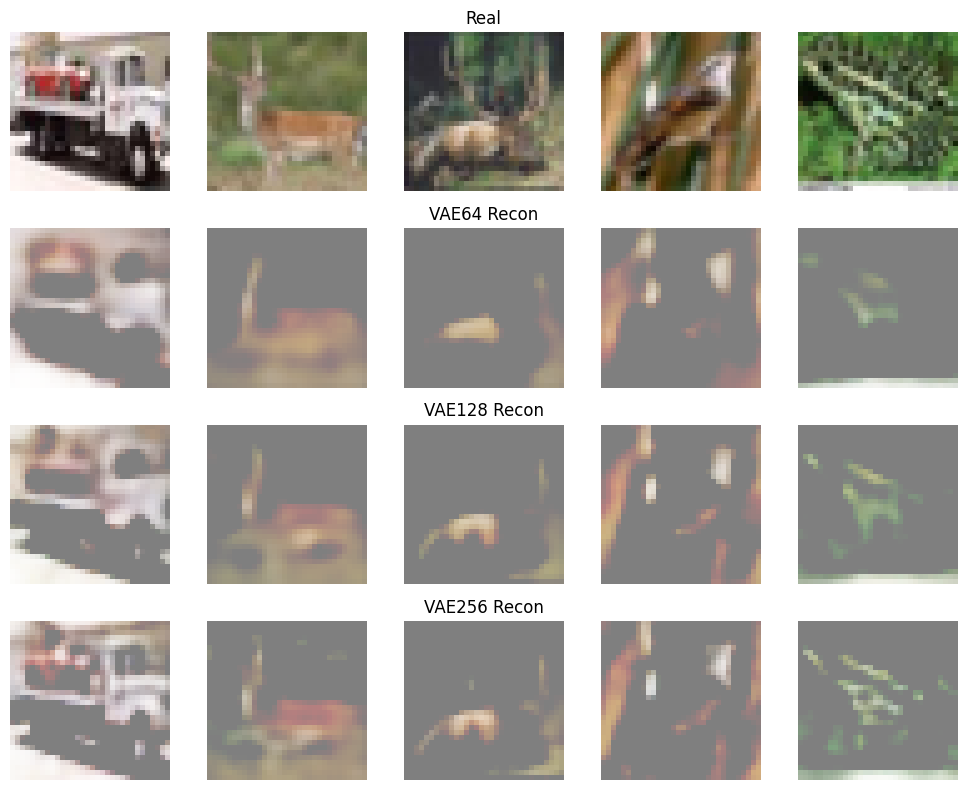

In [40]:
# -------------------------
# 1. Reconstructions
# -------------------------
with torch.no_grad():
    x_bar_64 = recon(vae64_no_anneal, real_images).cpu()
    x_bar_128 = recon(vae128_no_anneal, real_images).cpu()
    x_bar_256 = recon(vae256_no_anneal, real_images).cpu()

show_grid(
    [real_images, x_bar_64, x_bar_128, x_bar_256],
    ["Real", "VAE64 Recon", "VAE128 Recon", "VAE256 Recon"],
    n=n,
    subdir="1. Reconstructions vs. Generations/VAE Reconstructions",
    filename="vae64-128-256_no_anneal_reconstructions.png"
)

### GAN Generations

✅ Figure saved at: results/1. Reconstructions vs. Generations/GAN Reconstructions/gan64-128-256_generations.png


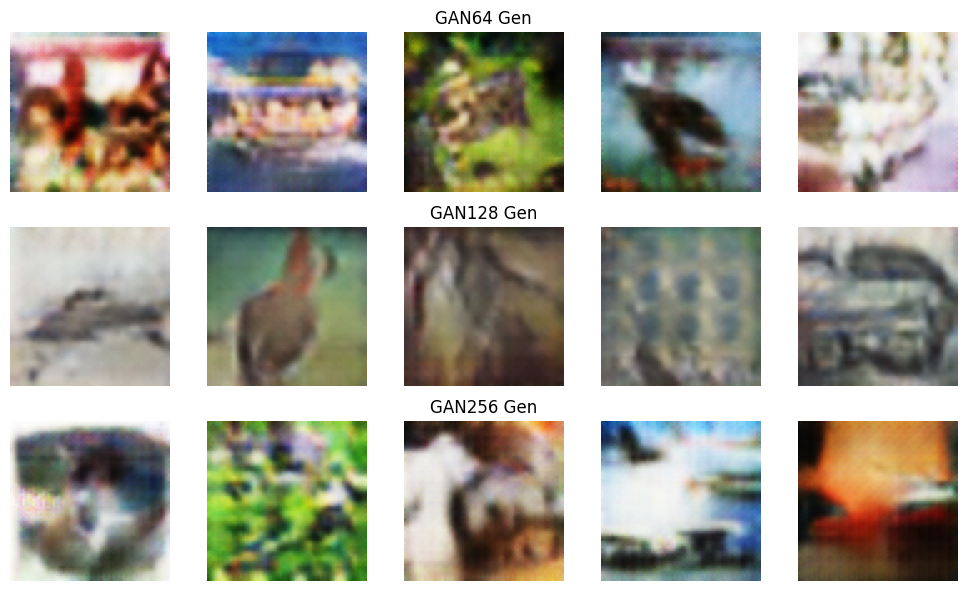

In [41]:
# -------------------------
# 2. GAN Generations
# -------------------------
with torch.no_grad():
    gen64 = gan_gen(gan64, n).cpu()
    gen128 = gan_gen(gan128, n).cpu()
    gen256 = gan_gen(gan256, n).cpu()

show_grid(
    [gen64, gen128, gen256],
    ["GAN64 Gen", "GAN128 Gen", "GAN256 Gen"],
    n=n,
    denorm=True,
    subdir="1. Reconstructions vs. Generations/GAN Reconstructions",
    filename="gan64-128-256_generations.png"
)

### VAE Generations

✅ Figure saved at: results/1. Reconstructions vs. Generations/VAE Generations/vae64-128-256_anneal_generations.png


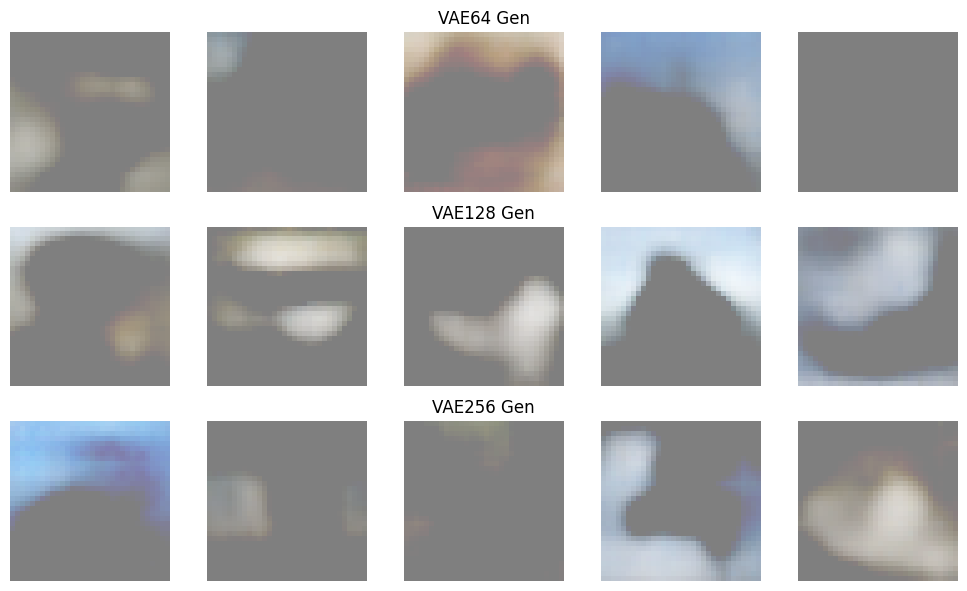

In [42]:
# -------------------------
# 3. VAE Generations
# -------------------------
with torch.no_grad():
    gen64 = vae_gen(vae64_anneal, n).cpu()
    gen128 = vae_gen(vae128_anneal, n).cpu()
    gen256 = vae_gen(vae256_anneal, n).cpu()

show_grid(
    [gen64, gen128, gen256],
    ["VAE64 Gen", "VAE128 Gen", "VAE256 Gen"],
    n=n,
    subdir="1. Reconstructions vs. Generations/VAE Generations",
    filename="vae64-128-256_anneal_generations.png"
)

### FID Metric
Compares the distribution of generated images with real images by embedding both into the feature space of a pretrained Inception-v3 network. It assumes those features follow a Gaussian, and computes the Fréchet distance between them.

Lower FID = generated samples are closer in distribution to real samples.

In [46]:
train_dataset.transform = transforms.ToTensor()
test_dataset.transform = transforms.ToTensor()

dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
dataloader = DataLoader(
    dataset=dataset,
    batch_size=128
)

In [53]:
# !pip uninstall -y torch-fidelity torchmetrics
# !pip install torch-fidelity
# !pip install torchmetrics

#### VAE Generations

In [54]:
num_batches = len(dataloader)
batch_size = dataloader.batch_size

In [ ]:
# setup fid instance to embed images in Inception-v3 pool3 layer
# 2048 features -> 2048-D embedding space
fid_vae = FrechetInceptionDistance(feature=2048).to(device)

# Real images
for real, _ in dataloader:
    fid_vae.update((real*255).to(device).to(torch.uint8), real=True)

In [255]:
# VAE Generated Samples
with torch.no_grad():
    for _ in range(num_batches):
        gen256_anneal = vae_gen(vae256_anneal, batch_size)
        fid_vae.update((gen256_anneal*255).to(torch.uint8), real=False)

print("VAE256 FID: ", fid_vae.compute().item())

VAE256 FID:  197.15908813476562


#### GAN Generations

In [260]:
fid_gan = FrechetInceptionDistance(feature=2048).to(device)

# Real images
for real, _ in dataloader:
    fid_gan.update((real*255).to(device).to(torch.uint8), real=True)

In [262]:
with torch.no_grad():
    for _ in range(num_batches):
        gen256 = gan_gen(gan256, batch_size)
        fid_gan.update((denormalize(gen256)*255).to(torch.uint8), real=False)

print("GAN256 FID: ", fid_gan.compute().item())

GAN256 FID:  73.52326202392578


### GAN Inception Score
IS measures both:
- Fidelity: Images should be confidently classified by Inception.

- Diversity: Across many samples, the predicted classes should be varied.

In [55]:
is_metric = InceptionScore().to(device)
with torch.no_grad():
    for i in range(num_batches):
        gen256 = gan_gen(gan256, batch_size)
        # if i % 100 == 0:
        #     # Take first 64 images for an 8x8 grid
        #     fake = gen256[:64].cpu()
        #     fake = denormalize(fake)

        #     grid = vutils.make_grid(fake, nrow=8, normalize=False)
        #     plt.figure(figsize=(8, 8))
        #     plt.axis("off")
        #     plt.title(f"GAN Samples at batch {i}")
        #     plt.imshow(grid.permute(1, 2, 0).numpy())
        #     plt.show()
        #     plt.close()
            
        is_metric.update((denormalize(gen256)*255).to(torch.uint8))

print("GAN Inception Score: ", is_metric.compute())

GAN Inception Score:  (tensor(5.3825, device='cuda:0'), tensor(0.0518, device='cuda:0'))


### VAE Reconstruction Error
Using MSELoss

In [49]:
recon_errors = []
with torch.no_grad():
    for x, _ in dataloader:
        x = x.to(device)
        mu, logvar, x_bar = vae256_no_anneal(x)
        mse = F.mse_loss(x_bar, x, reduction="mean")
        recon_errors.append(mse.item())

print("VAE Reconstruction Average MSE: ", sum(recon_errors)/len(recon_errors))

VAE Reconstruction Average MSE:  0.035889347633922784


## 2. Latent Space Structure

### 2.1 Linear Interpolation

#### VAE Latent Space

In [44]:
def interpolate_vae(model, img1, img2, steps=10, device="cuda"):
    model.eval()
    with torch.no_grad():
        # Encode both images to latent vectors
        mu1, logvar1, z1 = model.encode(img1.unsqueeze(0).to(device))
        mu2, logvar2, z2 = model.encode(img2.unsqueeze(0).to(device))

        # Linear interpolation in latent space
        alphas = torch.linspace(0, 1, steps).to(device)
        z_interp = torch.stack([(1-a)*z1 + a*z2 for a in alphas])

        # Decode to images
        recon = model.decode(z_interp).cpu()
    return recon

In [45]:
def plot_interpolation(images, title="Interpolation", dim=None, subdir=None, filename=None):
    steps = len(images)
    rows, cols = 2, steps // 2
    fig, axes = plt.subplots(rows, cols)
    axes = axes.flatten()
    for i, img in enumerate(images):
        axes[i].imshow(img.permute(1,2,0).cpu().numpy())
        axes[i].axis("off")
    if dim:
        fig.suptitle(f"{title} for Dimension {dim}", fontsize=14)
    else:
        fig.suptitle(title, fontsize=14)

    save_figure(fig, subdir, filename)
    
    plt.tight_layout()
    plt.show()

In [46]:
img1, lbl1 = dataset[100] # class 8 (ship?)
img2, lbl2 = dataset[1000] # class 9 (truck?)

✅ Figure saved at: results/2. Latent space structure/VAE Latent Linear Interpolation/vae256_no_anneal_interpolation.png


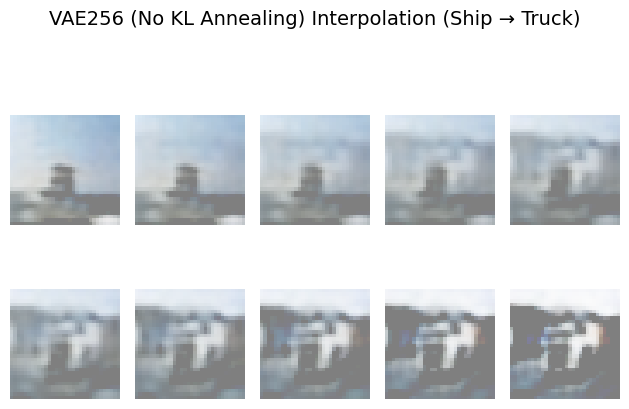

In [48]:
vae_interp = interpolate_vae(vae256_no_anneal, img1, img2)
plot_interpolation(vae_interp, title="VAE256 (No KL Annealing) Interpolation (Ship → Truck)",
                   subdir="2. Latent space structure/VAE Latent Linear Interpolation",
                   filename="vae256_no_anneal_interpolation.png")

✅ Figure saved at: results/2. Latent space structure/VAE Latent Linear Interpolation/vae256_anneal_interpolation.png


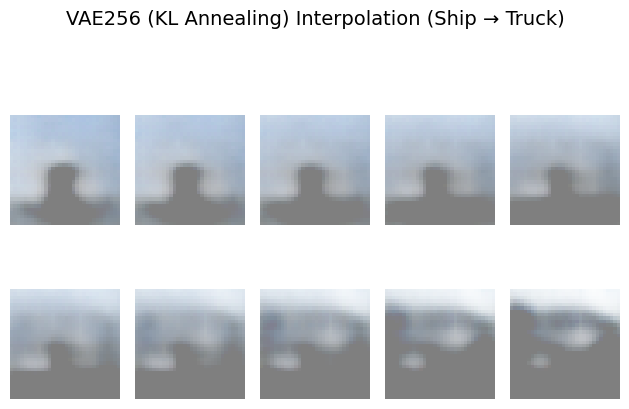

In [49]:
vae_interp = interpolate_vae(vae256_anneal, img1, img2)
plot_interpolation(vae_interp, title="VAE256 (KL Annealing) Interpolation (Ship → Truck)",
                  subdir="2. Latent space structure/VAE Latent Linear Interpolation",
                   filename="vae256_anneal_interpolation.png")

#### GAN Latent Space

In [51]:
def interpolate_gan(generator, z1, z2, steps=10, device="cuda"):
    generator.eval()
    with torch.no_grad():
        alphas = torch.linspace(0, 1, steps).to(device)
        z_interp = torch.stack([(1-a)*z1 + a*z2 for a in alphas])
        fake = generator(z_interp.squeeze(1)).cpu()
    return fake

✅ Figure saved at: results/2. Latent space structure/GAN Latent Linear Interpolation/gan256_interpolation.png


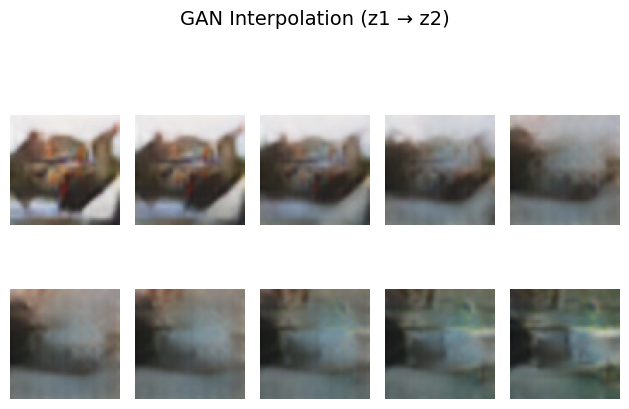

In [52]:
z1 = torch.randn(1, gan256.latent_dim, 1, 1, device=device)
z2 = torch.randn(1, gan256.latent_dim, 1, 1, device=device)

gan_interp = interpolate_gan(gan256, z1, z2, steps=10, device=device)
plot_interpolation([denormalize(img) for img in gan_interp], 
                   title="GAN Interpolation (z1 → z2)",
                  subdir="2. Latent space structure/GAN Latent Linear Interpolation",
                   filename="gan256_interpolation.png")

### 2.2 Latent Space Visualization

#### VAE Latent Representation

In [ ]:
# All latent_space plots recorded at end of training

#### GAN Latent Representation

In [ ]:
# No structure due to lack of encoder

### 2.3 Semantic Analysis

#### VAE Dimensional Variation

In [77]:
# High-level plan
    # Choose 5 random dimensions
    # Sweep each dimension independently from -5 to 5
    # Plot interpolation results
def latent_dimensional_variation(model, image, start=-5, end=5, dim=0, steps=10):
    with torch.no_grad():
        mu, logvar, z = model.encode(image.to(device)) # unsqueeze to add batch dimension to single image

        values = torch.linspace(start, end, steps).to(device)
        traversal_reconstructions = []
        for val in values:
            z_new = z.clone()
            z_new[dim] = val
            recon = model.decode(z_new.unsqueeze(0))
            traversal_reconstructions.append(recon.squeeze(0).detach())

    return traversal_reconstructions

✅ Figure saved at: results/2. Latent space structure/VAE Semantic Dimension Traversal/vae256_anneal_dimension174_sweep.png


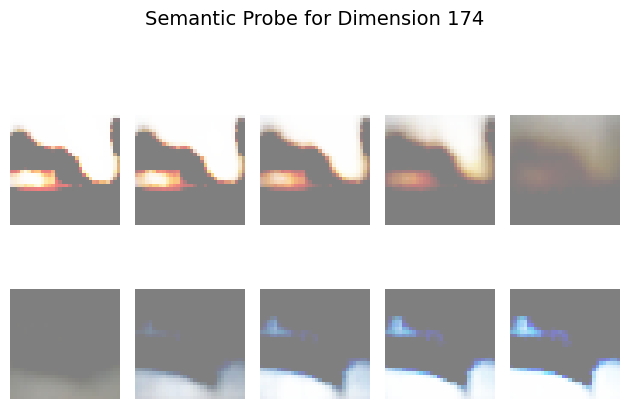

✅ Figure saved at: results/2. Latent space structure/VAE Semantic Dimension Traversal/vae256_anneal_dimension142_sweep.png


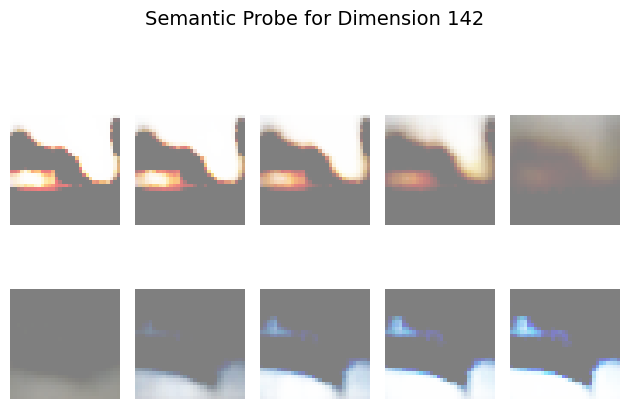

✅ Figure saved at: results/2. Latent space structure/VAE Semantic Dimension Traversal/vae256_anneal_dimension79_sweep.png


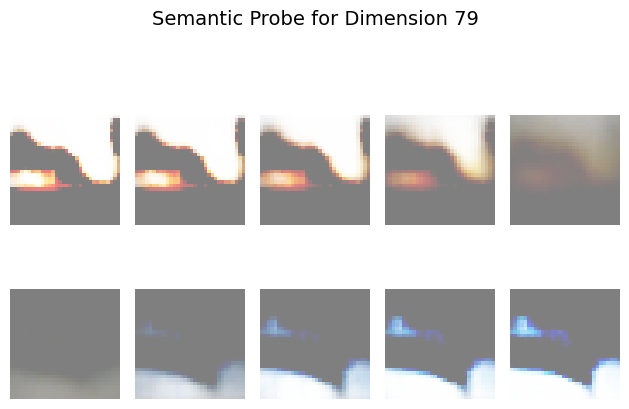

✅ Figure saved at: results/2. Latent space structure/VAE Semantic Dimension Traversal/vae256_anneal_dimension110_sweep.png


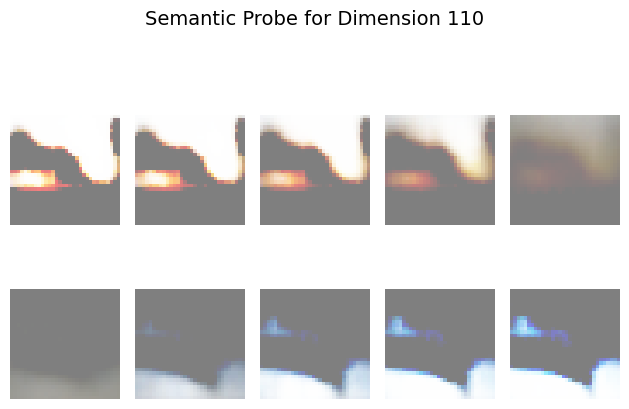

✅ Figure saved at: results/2. Latent space structure/VAE Semantic Dimension Traversal/vae256_anneal_dimension172_sweep.png


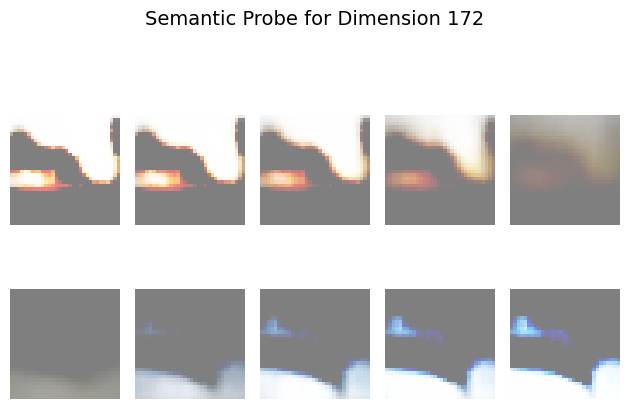

In [78]:
images, _ = next(iter(dataloader))
image = images[64]

# plt.imshow(image.permute(1,2,0))
# with torch.no_grad():
#     mu, logvar, z = vae256_no_anneal(image.to(device).unsqueeze(0))
#     plt.imshow(z.squeeze(0).permute(1,2,0).cpu())

dims = random.sample(range(vae256_anneal.latent_dim), 5)
for dim in dims:
    tr = latent_dimensional_variation(vae256_anneal, image)
    plot_interpolation(tr, title="Semantic Probe", dim=dim,
                      subdir="2. Latent space structure/VAE Semantic Dimension Traversal",
                   filename="vae256_anneal_dimension{dim}_sweep.png")

## 3. Out-of-Distribution (OOD) Inputs

### VAE OOD Reconstruction

In [57]:
# -----------------------------
# 1. Fetch image from URL
# -----------------------------
def fetch_image(url):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content)).convert("RGB")
    return img

In [80]:
# -----------------------------
# 2. Preprocess for VAE
# -----------------------------
def preprocess_image(img, size=32):  # adjust size (32/64/128/256) to match your VAE
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),  # [0,1]
        # only normalize if your VAE was trained with it!
        # transforms.Normalize((0.5,), (0.5,))
    ])
    return transform(img)  # add batch dim

In [64]:
imgs = {
    "earth": "https://i.pinimg.com/736x/35/d0/a0/35d0a0dffc5c1e77d53813464182720f.jpg",
    "waterfall": "https://pm1.aminoapps.com/6861/5bc2481e3779fcedfe23019bc53f1b95634f663fr1-1312-1309v2_hq.jpg",
    "rainbow": "https://art.pixilart.com/a7e7090593f500c.png",
    "anime_char": "https://dinopixel.com/preload/0524/pixel-art-1715512105.png",
    "spider-lily": "https://strapi.myplantin.com/large_main_1452eec5-ceb9-43f7-9d34-43b0ef2ea602.webp"
}

✅ Figure saved at: results/3. Out-of-Distribution Inputs/VAE/vae256_no_anneal_earth.png
Reconstruction Loss (MSE): 0.1346


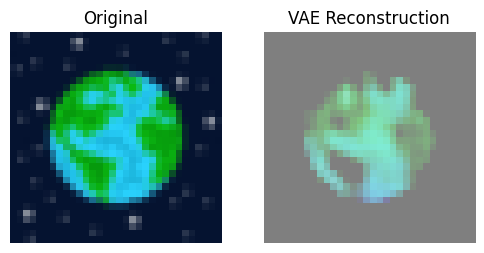

✅ Figure saved at: results/3. Out-of-Distribution Inputs/VAE/vae256_no_anneal_waterfall.png
Reconstruction Loss (MSE): 0.0949


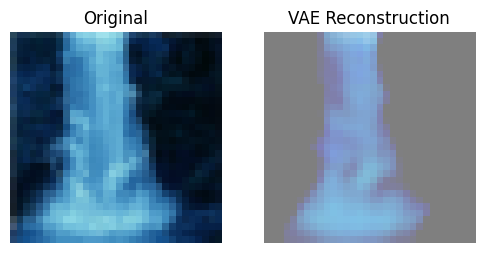

✅ Figure saved at: results/3. Out-of-Distribution Inputs/VAE/vae256_no_anneal_rainbow.png
Reconstruction Loss (MSE): 0.0387


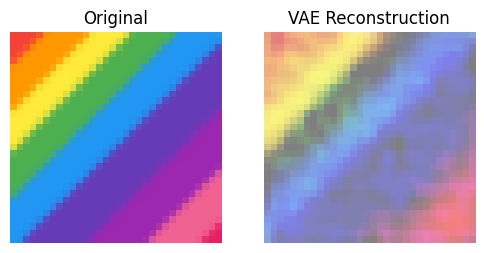

✅ Figure saved at: results/3. Out-of-Distribution Inputs/VAE/vae256_no_anneal_anime_char.png
Reconstruction Loss (MSE): 0.0287


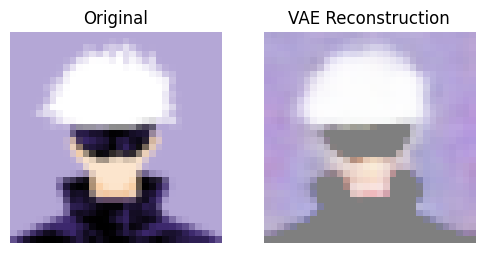

✅ Figure saved at: results/3. Out-of-Distribution Inputs/VAE/vae256_no_anneal_spider-lily.png
Reconstruction Loss (MSE): 0.0738


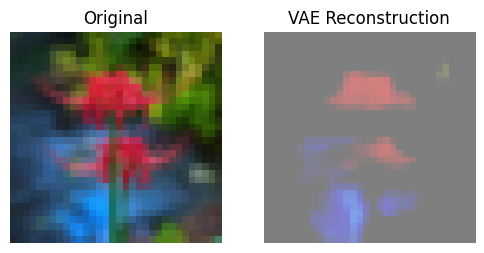

Average Reconstruction Loss on OOD Data:  0.07414636388421059


In [68]:
recon_losses = []
for img_name, url in imgs.items():
    
    img = fetch_image(url)
    img_tensor = preprocess_image(img, size=32).to(device)
    
    with torch.no_grad():
        mu, logvar, recon = vae256_no_anneal(img_tensor)
    
    recon_loss = F.mse_loss(recon, img_tensor).item()
    recon_losses.append(recon_loss)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(img_tensor.squeeze(0).permute(1, 2, 0).cpu())
    axes[0].set_title("Original")
    axes[0].axis("off")
    
    axes[1].imshow(recon.squeeze(0).permute(1, 2, 0).cpu())
    axes[1].set_title("VAE Reconstruction")
    axes[1].axis("off")
    
    save_figure(fig, subdir="3. Out-of-Distribution Inputs/VAE", filename=f"vae256_no_anneal_{img_name}.png")
    print(f"Reconstruction Loss (MSE): {recon_loss:.4f}")
    plt.show()

print("Average Reconstruction Loss on OOD Data: ", sum(recon_losses)/len(recon_losses))

### GAN OOD Latent Generation

✅ Figure saved at: results/3. Out-of-Distribution Inputs/GAN/gan64-128-256_scaled_generations.png


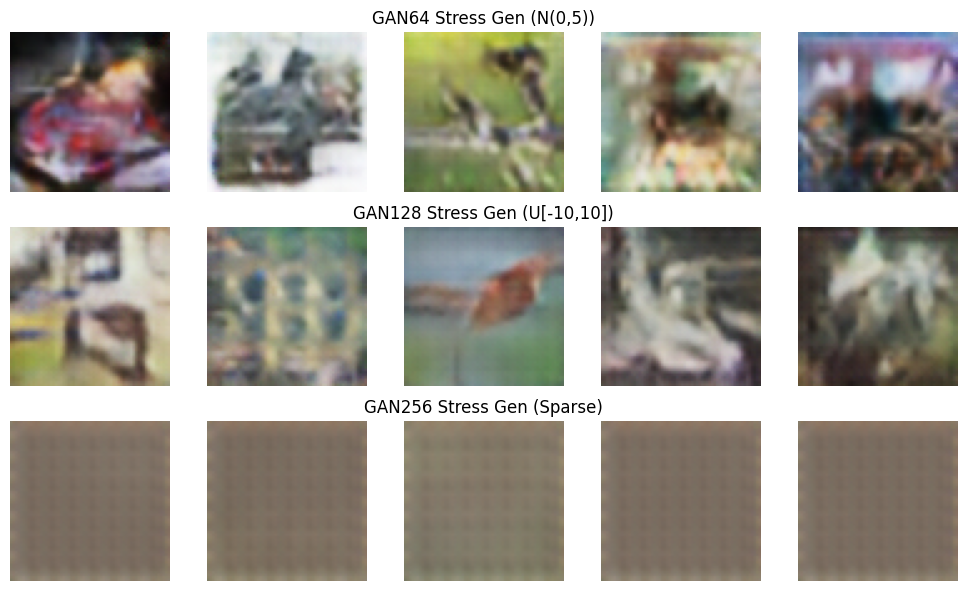

✅ Figure saved at: results/3. Out-of-Distribution Inputs/GAN/gan64-128-256_uniform_generations.png


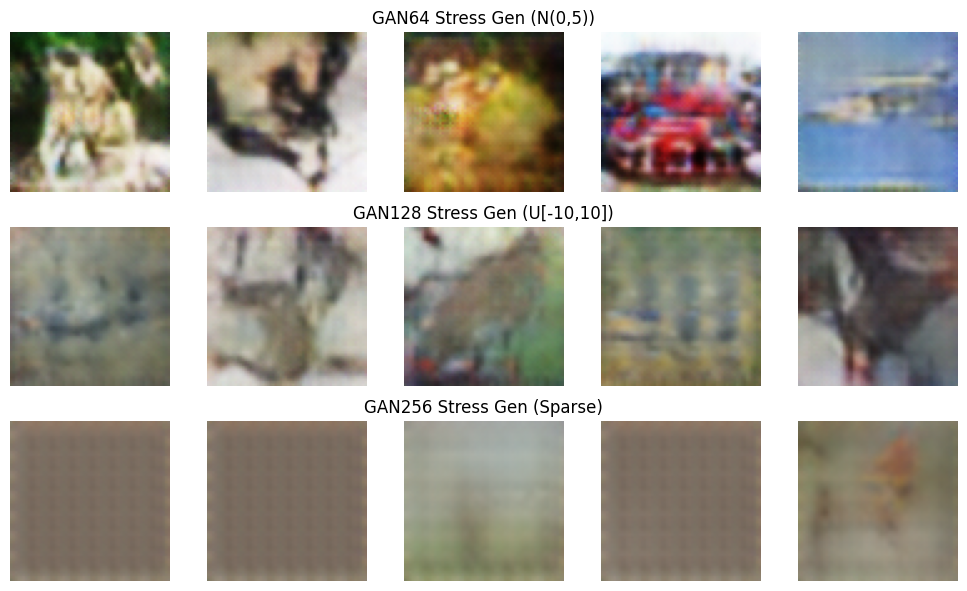

✅ Figure saved at: results/3. Out-of-Distribution Inputs/GAN/gan64-128-256_sparse_generations.png


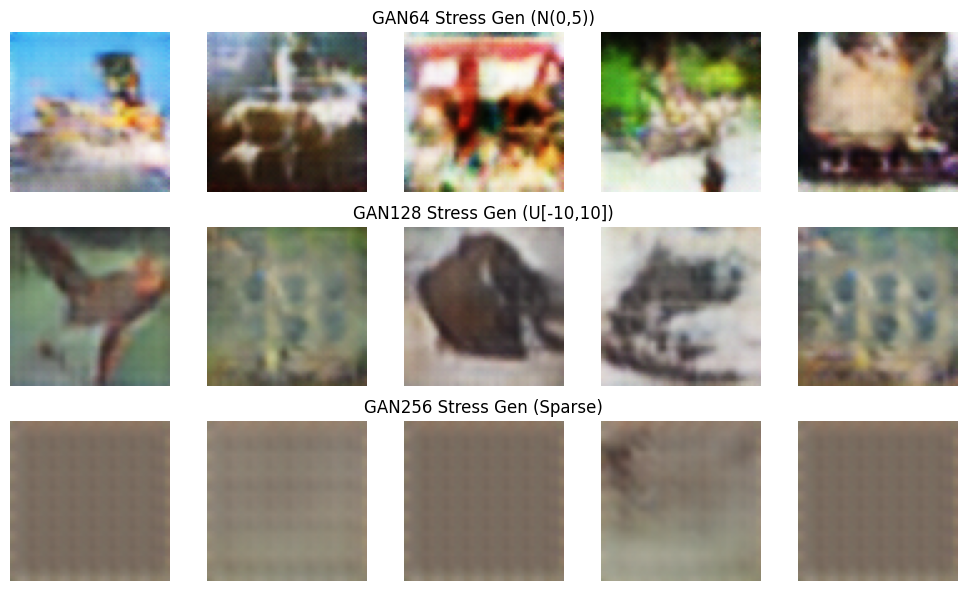

In [71]:
modes = ["scaled", "uniform", "sparse"]

for mode in modes:

    with torch.no_grad():
        gen64 = gan_gen(gan64, n, mode="scaled", scale=5).cpu()
        gen128 = gan_gen(gan128, n, mode="uniform", scale=10).cpu()
        gen256 = gan_gen(gan256, n, mode="sparse", scale=5).cpu()
    
    show_grid(
        [gen64, gen128, gen256],
        ["GAN64 Stress Gen (N(0,5))", "GAN128 Stress Gen (U[-10,10])", "GAN256 Stress Gen (Sparse)"],
        n=n,
        denorm=True,
        subdir="3. Out-of-Distribution Inputs/GAN",
        filename=f"gan64-128-256_{mode}_generations.png"
    )

### Anomaly Detection

In [97]:
def reconstruction_error(model, images):
    images = images.to(device)
    with torch.no_grad():
        mu, logvar, recon = model(images)
        mse = F.mse_loss(recon, images, reduction="none")
        mse_per_image = mse.view(mse.size(0), -1).mean(dim=1)
    return mse_per_image.cpu()

In [98]:
out_domain_images = torch.stack([preprocess_image(fetch_image(img)) for img in imgs.values()]).to(device)
in_domain_images, _ = next(iter(dataloader))
in_domain_images = in_domain_images.to(device)[:5] # only 5 images because have limited OOD data

In [100]:
id_errors = reconstruction_error(vae256_no_anneal, in_domain_images)

od_errors = reconstruction_error(vae256_no_anneal, out_domain_images)

print("In-domain errors:", id_errors.numpy())
print("Out-of-domain errors:", od_errors.numpy())

In-domain errors: [0.0095283  0.02852942 0.05962288 0.05696834 0.00661395]
Out-of-domain errors: [0.13465028 0.09492797 0.03866918 0.02871078 0.07378511]


✅ Figure saved at: results/3. Out-of-Distribution Inputs/VAE/vae256_no_anneal_anomalydetection.png


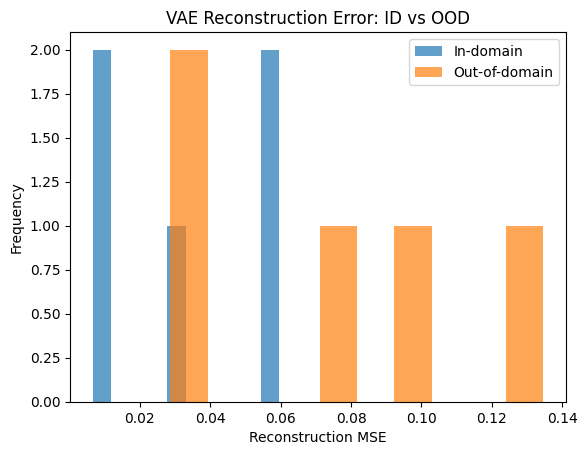

In [104]:
fig, ax = plt.subplots()

ax.hist(id_errors.numpy(), bins=10, alpha=0.7, label="In-domain")
ax.hist(od_errors.numpy(), bins=10, alpha=0.7, label="Out-of-domain")
ax.legend()
ax.set_xlabel("Reconstruction MSE")
ax.set_ylabel("Frequency")
ax.set_title("VAE Reconstruction Error: ID vs OOD")

save_figure(fig, subdir="3. Out-of-Distribution Inputs/VAE", filename="vae256_no_anneal_anomalydetection.png")

plt.show()